In [13]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks")
from multiclass_functions2_8 import * # all
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import copy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


In [14]:
BATCH_SIZE = 64
LR = 2e-3
LR_STEP = 3
LR_GAMMA = 0.9
EPOCH = 10
TRAIN_RATIO = 0.8
criterion = nn.CrossEntropyLoss()
new_model_train = False
model_type = "CNN_deep"
dataset = "STL10"
save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt"
save_history_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_history_{dataset}.pt"

In [15]:
def to_uint8(x):
    return (255*x).type(torch.uint8)

In [16]:
transform_train = transforms.Compose([
    transforms.ToTensor(),

    # transforms.Lambda(to_uint8),
    # to_uint8, # 가능
    # transforms.Lambda(lambda x:(255*x).type(torch.uint8)),
    # lambda x:(255*x).type(torch.uint8), # 가능
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # (아마도) 이미지넷 데이터 전체 픽셀에 대해서 구한 평균, std 값
    
    # transforms.Resize(size=(20,20)), # size는 (height,width)
    # transforms.CenterCrop(size=(20,20)), # size 는 (height, width)
    # transforms.Pad(6), # 20+6*2 = 32
    # transforms.RandomApply(nn.ModuleList([transforms.CenterCrop(size=(20,20)),
    #                                       transforms.Pad(6)]), p=0.5), # ModuleList 안해도 되더라
    # transforms.RandomCrop(size=(20,20)), # 어디를 자를지 random 하게 자름
    # transforms.RandomResizedCrop(size=(20,20), scale=(0.3,1), ratio=(0.3,1.7)),
    # random 하게 자른 다음에 resize라서 RandomCrop과 다름
    # scale은 어느 정도로 작은 범위를 자를지 (0~1 사이 값)
    # ratio는 aspect ratio로, 가로 길이/세로 길이 를 의미한다.
    # (a,b) <- a 와 b 사이 값을 uniform random 하게 뽑아요

    # transforms.RandomGrayscale(p=0.5), # gray로 바꾸는 데, 출력 채널 수를 3으로 유지
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5, hue=0.15), 
    # 밝기, 대비, 채도, 색조가 센서마다 다를 수 있음을 고려 (number: percentage to convert)
    # 밝기(brightness)를 키우면 밝은 부분에서 saturation이 일어나면서, HDR이 낮은 센서에 대응 가능
    # 대비(contrast) augmentation은 HDR이 서로 다른 센서에 대응 가능
    # 채도(saturation) 및 색조(hue) augmentation은 ISP에서 color correction matrix 값이 센서마다 서로 다른 경우 등,
    # 색 표현이 다른 센서에 대응 가능
    # transforms.RandomAutocontrast(p=0.5), # p의 확률로 대비를 자동 조정
    # transforms.RandomEqualize(p=0.5), # p의 확률로 R,G,B histogram을 일치시킴 (이건 uint8로 되어있는 이미지만 가능)
    # transforms.RandomInvert(p=0.5), # p의 확률로 색반전
    # new 픽셀 값 = 최댓 값 - 기존의 픽셀 값 을 통해 반전시킴
    # transforms.RandomSolarize(threshold=200, p=0.5), 
    # p의 확률로(즉 그 이미지에 대해 할지 말지 정하고) threshold 넘는 픽셀 값에 대해 inverting
    # transforms.RandomPosterize(bits=3, p=0.5),
    # 픽셀 하나가 가지는 값의 bit수(0~8)를 p의 확률로 bits로 바꿈 (이건 uint8로 되어있는 것만 가능)

    # transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,2)),
    # kernel_size = (가로,세로) sigma=(min,max) min ~ max 에서 uniform 하게 하나 뽑음
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    # sharpness_factor = 1 이면 원래 이미지, 0에 가까우면 blur, 1보다 클수록 sharp해짐

    # transforms.RandomHorizontalFlip(p=0.4), # p 확률로 좌우반전
    # transforms.RandomVerticalFlip(p=0.5), # p 확률로 상하반전
    # transforms.RandomRotation(degrees=(0,180)), # 0~180도 랜덤하게 회전
    # transforms.RandomAffine(degrees=(0,30),translate=(0.1,0.3),scale=(0.5,1.2)),
    # translate는 이동하는 정도 (비율), scale은 크기 조절
    # transforms.RandomPerspective(distortion_scale=0.6, p=0.5), # distortion 정도 0~1 사이, default는 0.5, p는 적용 확률
    
    # transforms.RandomErasing(p=0.5, scale=(0.03,0.3), ratio=(0.3,3.3)),
    # scale: 이미지의 몇 퍼 정도를 지울지
    # ratio: 지우는 영역의 aspect ratio

    # transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
    # AutoAugment:Learning Augmentation Strategies from Data 라는 논문에 따른 augmentation (uint8 이여야 함)
    # transforms.RandAugment(),
    # RandAugment: Practical automated data augmentation with a reduced search space 라는 논문에 따른 augmentation (uint8 이여야 함)
    # transforms.TrivialAugmentWide(),
    # TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation 라는 논문에 따른 augmentation (uint8)
    # transforms.AugMix(),
    # AugMix: A Simple Data Processing Method to Improve Robustness and Uncertainty 라는 논문에 따른 augmentaiton (uint8)
    ])
transform_test = transforms.ToTensor()

In [17]:
train_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform_train)
NoT = int(len(train_DS)*TRAIN_RATIO); NoV = len(train_DS) - NoT
train_DS, val_DS = torch.utils.data.random_split(train_DS, [NoT, NoV])
val_DS.transform = transform_test
test_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform_test)

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=False)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
# Albumentation 쓸 때만 주석 해제

transform_train = A.Compose([
    A.Resize(20,20),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    A.ShiftScaleRotate(shift_limit=(-0.05,0.05), scale_limit=(0,0), rotate_limit=(-10,10), p=0.7, border_mode=cv2.BORDER_CONSTANT), 
    A.RandomResizedCrop(height=20, width=20, scale=(0.3, 1), ratio=(0.75, 1.33), p=0.7), 

    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.8),
    
    A.OneOf([
             A.ElasticTransform(p=1, sigma=30, alpha=10, alpha_affine=5),
             #  sigma는 간격, alpha는 꼬불한 정도, alpla_affine은 affine transform의 정도
             A.GridDistortion(p=1), # grid로 쪼갠다음 각 patch들을 짜부시킴
             A.OpticalDistortion(p=1,distort_limit=1, shift_limit=0.5),
             #  distort_limit 가운데 부분이 볼록 튀어나와 보이는 정도 (0~1), shift_limit은 어느정도 이미지를 밀건지 (0~1)
             ], p=1),

    # A.Normalize(), # 애는 default가 0~255인 이미지가 들어오는 것으로 되어있어서 normalize 먼저
    ToTensorV2()])

transform_test = ToTensorV2() # unit8, 0~255는 그대로, Tensor, 개채행열로만 바꿔줌

class CIFAR10_custom(datasets.CIFAR10):
    def __init__(self, root="/content/drive/MyDrive/Colab Notebooks/data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image) # self.transform(image=image, mask=mask)
            image = transformed["image"]
            # mask = transformed["mask"]

        return image, label

test_DS = CIFAR10_custom(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform_test)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = False)

Files already downloaded and verified


x_batch size = torch.Size([64, 3, 32, 32])
x_batch size = torch.Size([64, 3, 20, 20])


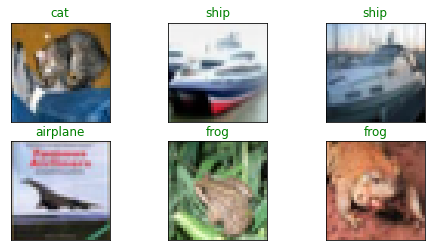

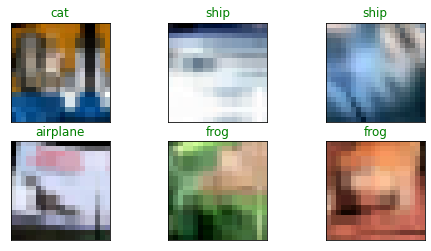

In [33]:
test_DS_wT = copy.deepcopy(test_DS) # wT = with Transform
test_DS_wT.transform = transform_train
test_DL_wT = torch.utils.data.DataLoader(test_DS_wT, batch_size = BATCH_SIZE, shuffle = False)

im_plot(test_DL)
im_plot(test_DL_wT)

In [20]:
print(train_DS)
print(test_DS)
print(len(train_DS))
print(len(test_DS))

Dataset CIFAR10_custom
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Test
    StandardTransform
Transform: ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
40000
10000


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'image': tensor([[[158, 159, 165,  ..., 137, 126, 116],
         [152, 151, 159,  ..., 136, 125, 119],
         [151, 151, 158,  ..., 139, 130, 120],
         ...,
         [ 68,  42,  31,  ...,  38,  13,  40],
         [ 61,  49,  35,  ...,  26,  29,  20],
         [ 54,  56,  45,  ...,  24,  34,  21]],

        [[112, 111, 116,  ...,  95,  91,  85],
         [112, 110, 114,  ...,  95,  91,  88],
         [110, 109, 111,  ...,  98,  95,  89],
         ...,
         [124, 100,  88,  ...,  97,  64,  85],
         [116, 102,  85,  ...,  82,  82,  64],
         [107, 105,  89,  ...,  77,  84,  67]],

        [[ 49,  47,  51,  ...,  36,  36,  33],
         [ 51,  40,  45,  ...,  31,  32,  34],
         [ 47,  33,  36,  ...,  34,  34,  33],
         ...,
         [177, 148, 137,  ..., 146, 108, 127],
         [168, 148, 132,  ..., 130, 126, 107],
         [160, 149, 132,  ..., 124, 129, 110]]], dtype

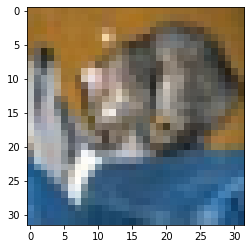

In [21]:
print(test_DS.classes)
x_batch, y_batch = next(iter(test_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(test_DS.classes[y_batch[0]])

In [22]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        
        self.classifier = nn.Sequential(nn.Linear(128*12*12,512),
                                        nn.Linear(512,10))
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [23]:
exec(f"model = {model_type}().to(DEVICE)")
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=

RuntimeError: ignored

In [ ]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.plot(range(1,EPOCH+1),loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("Train Loss")
    plt.grid()

In [ ]:
load_model = torch.load(save_model_path, map_location=DEVICE)

In [ ]:
Test(load_model, test_DL)
print(count_params(load_model))

In [ ]:
Test_plot(load_model, test_DL)

In [ ]:
import time
epoch_start = time.time()
for _ in range(100000):
    a=1
time.time()-epoch_start

In [ ]:
~

In [ ]:
~